# Classificação de Supercondutores usando Machine Learning

Este notebook treina 3 modelos diferentes para classificar se um material é supercondutor baseado em suas propriedades físicas e estruturais.

## Objetivo
- **Variável Target**: Classificação binária baseada na temperatura crítica (Tc)
  - Supercondutor: Tc > 0
  - Não-supercondutor: Tc = 0 ou NaN
- **Features**: Propriedades dos materiais (átomos, célula unitária, bandas eletrônicas, etc.)

## Modelos a serem comparados:
1. **Random Forest** - Ensemble baseado em árvores
2. **XGBoost** - Gradient boosting otimizado
3. **Support Vector Machine (SVM)** - Classificador com kernel RBF

## 1. Importação de Bibliotecas e Configurações

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import os

from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, cross_val_score, 
    StratifiedKFold, learning_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, accuracy_score,
    precision_score, recall_score
)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

import xgboost as xgb

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
np.random.seed(42)

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

os.makedirs('graficos_supercondutores', exist_ok=True)

## 2. Carregamento e Análise Exploratória dos Dados

In [48]:
# Carregamento dos dados
df = pd.read_csv('data_treino.csv')

print(f"Dataset carregado:")
print(f"   - Dimensões: {df.shape}")
print(f"   - Colunas: {df.shape[1]}")
print(f"   - Linhas: {df.shape[0]}")

# Informações básicas
print(f"\nInformações da variável target (Tc):")
print(f"   - Valores não-nulos: {df['Tc'].notna().sum()}")
print(f"   - Valores nulos: {df['Tc'].isna().sum()}")
print(f"   - Valores únicos: {df['Tc'].nunique()}")
print(f"   - Faixa: {df['Tc'].min():.2f} - {df['Tc'].max():.2f}")

# Primeiras linhas
display(df.head())

Dataset carregado:
   - Dimensões: (2474, 131)
   - Colunas: 131
   - Linhas: 2474

Informações da variável target (Tc):
   - Valores não-nulos: 1363
   - Valores nulos: 1111
   - Valores únicos: 578
   - Faixa: 0.00 - 134.00


,group_id,atoms_size,atoms_0,atoms_1,atoms_2,atoms_3,atoms_4,atoms_5,atoms_6,atoms_7,...,fermi_line_4_0,fermi_line_4_1,fermi_line_4_2,fermi_line_5_0,fermi_line_5_1,fermi_line_5_2,fermi_lens_shape_1,fermi_line_shape_1,id,Tc
0,10007,8,Ag,Ag,Ag,Ag,Hg,Hg,Hg,Hg,...,NaN,NaN,NaN,NaN,NaN,NaN,38.0,10806.0,10007,0.64
1,10010,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,24.0,10010,1.21
2,10011,6,Th,Th,Th,Th,Ag,Pd,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33.0,14698.0,10011,1.20
3,10015,6,Al,Al,Ag,Ag,Ag,Ag,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,45944.0,10015,0.13
4,10019,4,Ag,Ag,Ag,Hg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,12870.0,10019,NaN


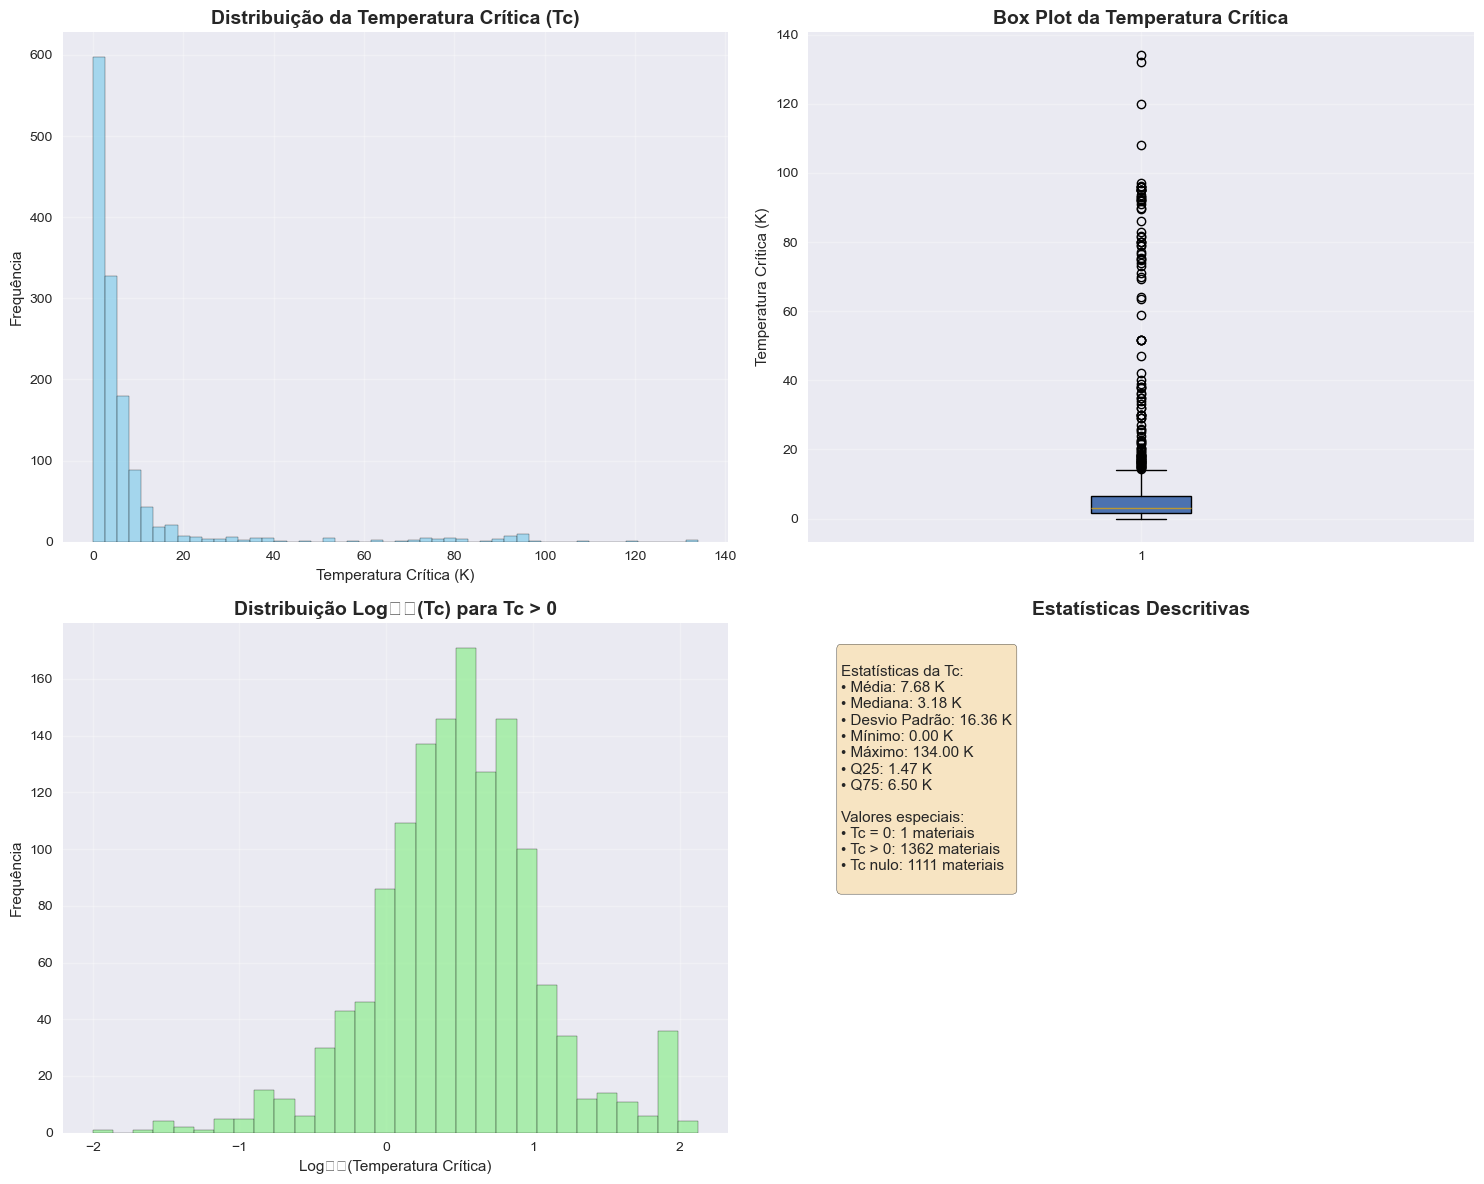

In [49]:
# Análise da distribuição da temperatura crítica
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Histograma da Tc
axes[0, 0].hist(df['Tc'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribuição da Temperatura Crítica (Tc)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Temperatura Crítica (K)')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].grid(True, alpha=0.3)

# Box plot da Tc
axes[0, 1].boxplot(df['Tc'].dropna(), patch_artist=True)
axes[0, 1].set_title('Box Plot da Temperatura Crítica', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Temperatura Crítica (K)')
axes[0, 1].grid(True, alpha=0.3)

# Log da Tc (para valores > 0)
tc_positive = df[df['Tc'] > 0]['Tc']
if len(tc_positive) > 0:
    axes[1, 0].hist(np.log10(tc_positive), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 0].set_title('Distribuição Log₁₀(Tc) para Tc > 0', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Log₁₀(Temperatura Crítica)')
    axes[1, 0].set_ylabel('Frequência')
    axes[1, 0].grid(True, alpha=0.3)

# Estatísticas descritivas
stats_text = f"""
Estatísticas da Tc:
• Média: {df['Tc'].mean():.2f} K
• Mediana: {df['Tc'].median():.2f} K
• Desvio Padrão: {df['Tc'].std():.2f} K
• Mínimo: {df['Tc'].min():.2f} K
• Máximo: {df['Tc'].max():.2f} K
• Q25: {df['Tc'].quantile(0.25):.2f} K
• Q75: {df['Tc'].quantile(0.75):.2f} K

Valores especiais:
• Tc = 0: {(df['Tc'] == 0).sum()} materiais
• Tc > 0: {(df['Tc'] > 0).sum()} materiais
• Tc nulo: {df['Tc'].isna().sum()} materiais
"""

axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes, 
                fontsize=11, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')
axes[1, 1].set_title('Estatísticas Descritivas', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_supercondutores/01_analise_exploratoria_tc.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Preparação dos Dados e Feature Engineering

Variável target criada:
   - Supercondutores (Tc > 0): 1362
   - Não-supercondutores: 1112
   - Proporção de supercondutores: 0.551


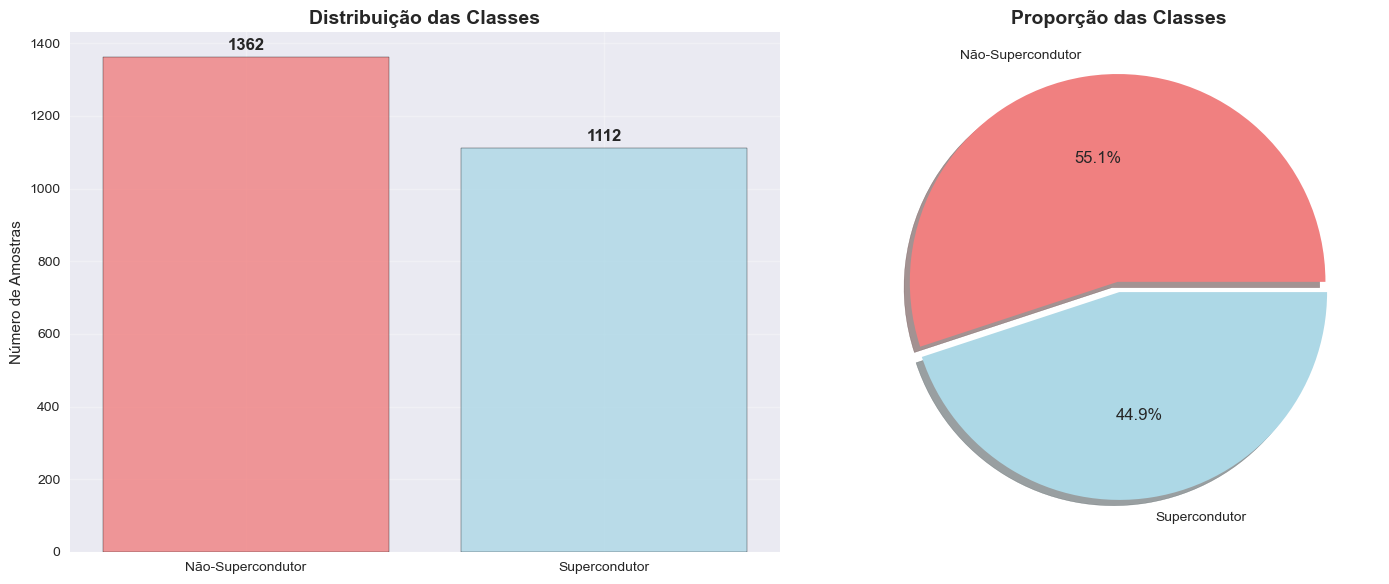

In [50]:
# Criação da variável target 
df['is_superconductor'] = ((df['Tc'] > 0) & (df['Tc'].notna())).astype(int)

print(f"Variável target criada:")
print(f"   - Supercondutores (Tc > 0): {df['is_superconductor'].sum()}")
print(f"   - Não-supercondutores: {(df['is_superconductor'] == 0).sum()}")
print(f"   - Proporção de supercondutores: {df['is_superconductor'].mean():.3f}")

# Visualização da distribuição das classes
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Contagem das classes
class_counts = df['is_superconductor'].value_counts()
axes[0].bar(['Não-Supercondutor', 'Supercondutor'], class_counts.values, 
           color=['lightcoral', 'lightblue'], alpha=0.8, edgecolor='black')
axes[0].set_title('Distribuição das Classes', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Número de Amostras')
axes[0].grid(True, alpha=0.3)

# Adiciona valores nas barras
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Pizza chart
axes[1].pie(class_counts.values, labels=['Não-Supercondutor', 'Supercondutor'], 
           autopct='%1.1f%%', colors=['lightcoral', 'lightblue'], 
           explode=(0.05, 0), shadow=True)
axes[1].set_title('Proporção das Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_supercondutores/02_distribuicao_classes.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
# Preparação das features
print(" Preparando features...")

# Remove colunas não necessárias para o modelo
columns_to_drop = ['Tc', 'Unnamed: 0', 'group_id', 'id']  # Remove target original e identificadores
available_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
feature_columns = [col for col in df.columns if col not in available_columns_to_drop + ['is_superconductor']]

print(f"   - Features disponíveis: {len(feature_columns)}")
print(f"   - Colunas removidas: {available_columns_to_drop}")

# Separação de features categóricas e numéricas
categorical_features = []
numerical_features = []

for col in feature_columns:
    if df[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"   - Features categóricas: {len(categorical_features)}")
print(f"   - Features numéricas: {len(numerical_features)}")

# Tratamento de features categóricas (átomos)
atom_columns = [col for col in categorical_features if col.startswith('atoms_')]
print(f"   - Colunas de átomos: {len(atom_columns)}")

# Codificação das features categóricas
df_processed = df.copy()
label_encoders = {}

for col in atom_columns:
    le = LabelEncoder()
    # Preenche valores nulos com 'None'
    df_processed[col] = df_processed[col].fillna('None')
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# Análise de valores ausentes
missing_data = df_processed[feature_columns].isnull().sum()
missing_percent = (missing_data / len(df_processed)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percent': missing_percent.values
}).sort_values('Missing_Percent', ascending=False)

# Mostra features com mais valores ausentes
print(f"\n Top 10 features com mais valores ausentes:")
print(missing_df.head(10).to_string(index=False))

 Preparando features...
   - Features disponíveis: 128
   - Colunas removidas: ['Tc', 'group_id', 'id']
   - Features categóricas: 12
   - Features numéricas: 116
   - Colunas de átomos: 12

 Top 10 features com mais valores ausentes:
         Column  Missing_Count  Missing_Percent
fermi_lens_mean           2472        99.919159
 fermi_lens_max           2472        99.919159
 fermi_lens_min           2472        99.919159
 fermi_lens_std           2472        99.919159
 fermi_line_2_0           2464        99.595796
 fermi_line_0_2           2464        99.595796
 fermi_line_0_0           2464        99.595796
 fermi_line_1_1           2464        99.595796
 fermi_line_1_2           2464        99.595796
 fermi_line_1_0           2464        99.595796


In [52]:
# Remove features com muitos valores ausentes (>70%)
features_to_keep = missing_df[missing_df['Missing_Percent'] <= 70]['Column'].tolist()
print(f"   - Features mantidas (≤70% missing): {len(features_to_keep)}")
print(f"   - Features removidas (>70% missing): {len(feature_columns) - len(features_to_keep)}")

# Dataset final para modelagem
X = df_processed[features_to_keep]
y = df_processed['is_superconductor']

# Remove amostras onde o target é indefinido (apenas para ter certeza)
valid_indices = y.notna()
X = X[valid_indices]
y = y[valid_indices]

print(f"   - Amostras finais: {len(X)}")
print(f"   - Features finais: {X.shape[1]}")
print(f"   - Distribuição das classes: {y.value_counts().to_dict()}")

# Imputação de valores ausentes
print(f"\n Aplicando imputação de valores ausentes...")
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X), 
    columns=X.columns, 
    index=X.index
)

print(f"   - Valores ausentes restantes: {X_imputed.isnull().sum().sum()}")

   - Features mantidas (≤70% missing): 72
   - Features removidas (>70% missing): 56
   - Amostras finais: 2474
   - Features finais: 72
   - Distribuição das classes: {1: 1362, 0: 1112}

 Aplicando imputação de valores ausentes...
   - Valores ausentes restantes: 0


## 4. Seleção de Features

In [53]:
# Seleção de features usando SelectKBest
print(" Selecionando as melhores features...")

# Seleciona as top 50 features (ou menos se não houver tantas)
k_best = min(50, X_imputed.shape[1])
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X_imputed, y)

# Obtém os nomes das features selecionadas
selected_features = X_imputed.columns[selector.get_support()].tolist()
feature_scores = selector.scores_[selector.get_support()]

print(f"   {k_best} melhores features selecionadas")
print(f"\n Top 15 features selecionadas:")

feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Score': feature_scores
}).sort_values('Score', ascending=False)

for i, (_, row) in enumerate(feature_importance_df.head(15).iterrows()):
    print(f"{i+1:2d}. {row['Feature']:<30} | Score: {row['Score']:.2f}")

# Cria DataFrame final com features selecionadas
X_final = pd.DataFrame(X_selected, columns=selected_features, index=X_imputed.index)

print(f"\n Dataset final para modelagem:")
print(f"   - Amostras: {X_final.shape[0]}")
print(f"   - Features: {X_final.shape[1]}")
print(f"   - Classe positiva: {y.sum()} ({y.mean():.3f})")
print(f"   - Classe negativa: {(y == 0).sum()} ({(y == 0).mean():.3f})")

 Selecionando as melhores features...
   50 melhores features selecionadas

 Top 15 features selecionadas:
 1. sc_DOSs_mean                   | Score: 43.84
 2. atoms_2                        | Score: 38.68
 3. sc_bands_mean                  | Score: 28.16
 4. recip_latt_1_0                 | Score: 27.04
 5. sc_DOSs_min                    | Score: 27.02
 6. atoms_1                        | Score: 17.77
 7. position_1_0                   | Score: 16.62
 8. atoms_3                        | Score: 16.42
 9. cell_1_0                       | Score: 16.34
10. atoms_7                        | Score: 13.38
11. atoms_4                        | Score: 11.16
12. position_3_2                   | Score: 10.62
13. position_2_2                   | Score: 10.28
14. position_2_0                   | Score: 10.07
15. atoms_6                        | Score: 9.92

 Dataset final para modelagem:
   - Amostras: 2474
   - Features: 50
   - Classe positiva: 1362 (0.551)
   - Classe negativa: 1112 (0.449)


## 5. Divisão dos Dados e Padronização

In [54]:
# Divisão treino/teste estratificada

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"    Divisão concluída")
print(f"   - Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X_final):.1%})")
print(f"   - Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X_final):.1%})")
print(f"   - Proporção classe positiva (treino): {y_train.mean():.3f}")
print(f"   - Proporção classe positiva (teste): {y_test.mean():.3f}")

# Padronização das features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converte de volta para DataFrame para facilitar manipulação
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"   - Média das features (treino): {X_train_scaled.mean().mean():.6f}")
print(f"   - Desvio padrão das features (treino): {X_train_scaled.std().mean():.6f}")

    Divisão concluída
   - Treino: 1979 amostras (80.0%)
   - Teste: 495 amostras (20.0%)
   - Proporção classe positiva (treino): 0.550
   - Proporção classe positiva (teste): 0.552
   - Média das features (treino): -0.000000
   - Desvio padrão das features (treino): 1.000253


## 6. Definição dos Modelos e Hiperparâmetros

In [55]:
# Definição dos modelos e seus hiperparâmetros
# Random Forest
rf_params = {
    'n_estimators': [50, 100, 200, 300, 500, 800],
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'criterion': ['gini', 'entropy']
}

# Support Vector Machine
svm_params = {
    'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None],
    'probability': [True],  
    'degree': [2, 3, 4, 5],  
    'coef0': [0.0, 0.1, 0.5, 1.0]  
}

# Instanciação dos modelos
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': rf_params,
        'description': 'Ensemble de árvores de decisão com votação majoritária'
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': svm_params,
        'description': 'Máquina de vetores de suporte com kernel RBF'
    }
}

# XGBoost

xgb_params = {
    'n_estimators': [50, 100, 200, 300, 500, 800],
    'max_depth': [3, 4, 5, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1, 2],
    'reg_lambda': [0.5, 1, 1.5, 2, 3, 5],
    'scale_pos_weight': [1, 2, 3, 4, 5],  
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.5, 1]
}

models['XGBoost'] = {
    'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'params': xgb_params,
    'description': 'Gradient boosting otimizado com regularização'
}

print(f"    {len(models)} modelos configurados:")
for name, config in models.items():
    param_combinations = 1
    for param_values in config['params'].values():
        param_combinations *= len(param_values)
    print(f"   - {name}: {param_combinations:,} combinações possíveis")
    print(f"     └─ {config['description']}")

# Configuração do Randomized Search (AUMENTADO)
cv_folds = 5
n_iter = 100  # AUMENTADO de 30 para 100
scoring = 'f1'  # Métrica de otimização

print(f"\n Configuração do Randomized Search:")
print(f"   - Cross-validation: {cv_folds} folds")
print(f"   - Iterações por modelo: {n_iter}")
print(f"   - Métrica de otimização: {scoring}")
print(f"   - Total de treinamentos: {len(models) * n_iter * cv_folds:,}")

    3 modelos configurados:
   - Random Forest: 75,600 combinações possíveis
     └─ Ensemble de árvores de decisão com votação majoritária
   - SVM: 7,680 combinações possíveis
     └─ Máquina de vetores de suporte com kernel RBF
   - XGBoost: 22,680,000 combinações possíveis
     └─ Gradient boosting otimizado com regularização

 Configuração do Randomized Search:
   - Cross-validation: 5 folds
   - Iterações por modelo: 100
   - Métrica de otimização: f1
   - Total de treinamentos: 1,500


## 7. Treinamento dos Modelos com Randomized Search

In [56]:
# Treinamento dos modelos com Randomized Search
print("Iniciando...")

# Dicionário para armazenar resultados
results = {}
best_models = {}

# Cross-validation estratificada
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Treina cada modelo
for model_name, config in models.items():
    print(f"Treinando {model_name}...")
    
    try:
        # Configura o Randomized Search
        random_search = RandomizedSearchCV(
            estimator=config['model'],
            param_distributions=config['params'],
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            random_state=42,
            verbose=1  
        )
        
        # Treina o modelo
        random_search.fit(X_train_scaled, y_train)
        
        # Armazena resultados
        results[model_name] = {
            'best_score': random_search.best_score_,
            'best_params': random_search.best_params_,
            'cv_results': random_search.cv_results_,
            'search_object': random_search
        }
        
        best_models[model_name] = random_search.best_estimator_
        
        print(f"   {model_name} concluído")
        print(f"     └─ Melhor score CV: {random_search.best_score_:.4f}")
        print(f"     └─ Melhores parâmetros: {random_search.best_params_}\n")
        
    except Exception as e:
        print(f"   Erro ao treinar {model_name}: {e}")
        continue

print(f" Treinamento concluído! {len(best_models)} modelos treinados com sucesso.")

Iniciando...
Treinando Random Forest...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
   Random Forest concluído
     └─ Melhor score CV: 0.7131
     └─ Melhores parâmetros: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 5, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Treinando SVM...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
   SVM concluído
     └─ Melhor score CV: 0.7155
     └─ Melhores parâmetros: {'probability': True, 'kernel': 'rbf', 'gamma': 10, 'degree': 4, 'coef0': 0.1, 'class_weight': 'balanced', 'C': 10}

Treinando XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
   XGBoost concluído
     └─ Melhor score CV: 0.7365
     └─ Melhores parâmetros: {'subsample': 0.6, 'scale_pos_weight': 5, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8}



## 8. Avaliação dos Modelos no Conjunto de Teste

In [57]:
test_results = {}

# Avalia cada modelo
for model_name, model in best_models.items():
    
    try:
        # Predições
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Metricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Armazena resultados
        test_results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        print(f"   ✓ Accuracy: {accuracy:.4f}")
        print(f"   ✓ Precision: {precision:.4f}")
        print(f"   ✓ Recall: {recall:.4f}")
        print(f"   ✓ F1-Score: {f1:.4f}")
        print(f"   ✓ AUC-ROC: {auc:.4f}")
        
    except Exception as e:
        print(f"    Erro ao avaliar {model_name}: {e}")
        continue

   ✓ Accuracy: 0.6101
   ✓ Precision: 0.6058
   ✓ Recall: 0.8388
   ✓ F1-Score: 0.7035
   ✓ AUC-ROC: 0.6661
   ✓ Accuracy: 0.5697
   ✓ Precision: 0.5625
   ✓ Recall: 0.9890
   ✓ F1-Score: 0.7171
   ✓ AUC-ROC: 0.5985
   ✓ Accuracy: 0.6182
   ✓ Precision: 0.5981
   ✓ Recall: 0.9377
   ✓ F1-Score: 0.7304
   ✓ AUC-ROC: 0.7116


In [58]:
# Tabela comparativa das métricas
if test_results:
    print("Tabela Comparativa de Performance:")
    print("-------------------------------------------------------------------------")
    
    # Cria DataFrame com métricas
    metrics_df = pd.DataFrame({
        'Modelo': list(test_results.keys()),
        'Accuracy': [test_results[model]['accuracy'] for model in test_results.keys()],
        'Precision': [test_results[model]['precision'] for model in test_results.keys()],
        'Recall': [test_results[model]['recall'] for model in test_results.keys()],
        'F1-Score': [test_results[model]['f1'] for model in test_results.keys()],
        'AUC-ROC': [test_results[model]['auc'] for model in test_results.keys()]
    })
    
    # Formata para exibicao
    metrics_display = metrics_df.copy()
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']:
        metrics_display[col] = metrics_display[col].apply(lambda x: f'{x:.4f}')
    
    print(metrics_display.to_string(index=False))
    
    # Identifica o melhor modelo para cada metrica
    print("\n Melhor modelo por metrica:")
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']:
        best_idx = metrics_df[col].idxmax()
        best_model = metrics_df.loc[best_idx, 'Modelo']
        best_score = metrics_df.loc[best_idx, col]
        print(f"   - {col}: {best_model} ({best_score:.4f})")
        
    # Define melhor modelo geral (baseado em F1-Score)
    best_overall_model = metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'Modelo']
    best_f1_score = metrics_df['F1-Score'].max()
    
else:
    print("Nenhum modelo foi avaliado com sucesso.")
    best_overall_model = None
    best_f1_score = 0

Tabela Comparativa de Performance:
-------------------------------------------------------------------------
       Modelo Accuracy Precision Recall F1-Score AUC-ROC
Random Forest   0.6101    0.6058 0.8388   0.7035  0.6661
          SVM   0.5697    0.5625 0.9890   0.7171  0.5985
      XGBoost   0.6182    0.5981 0.9377   0.7304  0.7116

 Melhor modelo por metrica:
   - Accuracy: XGBoost (0.6182)
   - Precision: Random Forest (0.6058)
   - Recall: SVM (0.9890)
   - F1-Score: XGBoost (0.7304)
   - AUC-ROC: XGBoost (0.7116)


## 9. Visualização dos Resultados

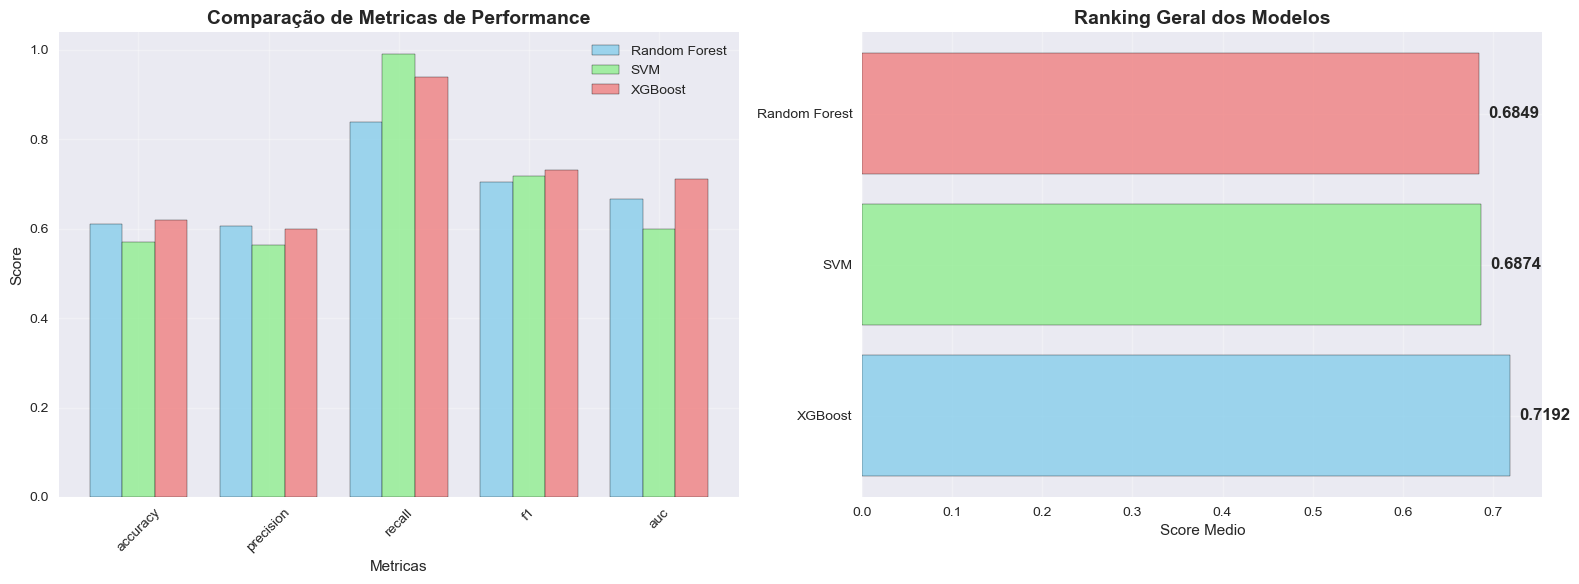

In [59]:
if test_results and len(test_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Grafico de barras das metricas
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    x_pos = np.arange(len(metrics_to_plot))
    width = 0.25
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink']
    
    for i, (model_name, color) in enumerate(zip(test_results.keys(), colors[:len(test_results)])):
        values = [test_results[model_name][metric.lower().replace('-', '_')] for metric in metrics_to_plot]
        axes[0].bar(x_pos + i*width, values, width, label=model_name, 
                   color=color, alpha=0.8, edgecolor='black')
    
    axes[0].set_xlabel('Metricas')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Comparação de Metricas de Performance', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x_pos + width)
    axes[0].set_xticklabels(metrics_to_plot, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Ranking dos modelos (media das metricas)
    model_ranking = []
    for model_name in test_results.keys():
        avg_score = np.mean([test_results[model_name][metric.lower().replace('-', '_')] 
                            for metric in metrics_to_plot])
        model_ranking.append((model_name, avg_score))
    
    model_ranking.sort(key=lambda x: x[1], reverse=True)
    models_ranked = [x[0] for x in model_ranking]
    scores_ranked = [x[1] for x in model_ranking]
    
    bars = axes[1].barh(models_ranked, scores_ranked, 
                       color=colors[:len(models_ranked)], alpha=0.8, edgecolor='black')
    axes[1].set_xlabel('Score Medio')
    axes[1].set_title('Ranking Geral dos Modelos', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Adiciona valores nas barras
    for bar, score in zip(bars, scores_ranked):
        axes[1].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{score:.4f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('graficos_supercondutores/03_comparacao_modelos.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(" Não há resultados para visualizar.")

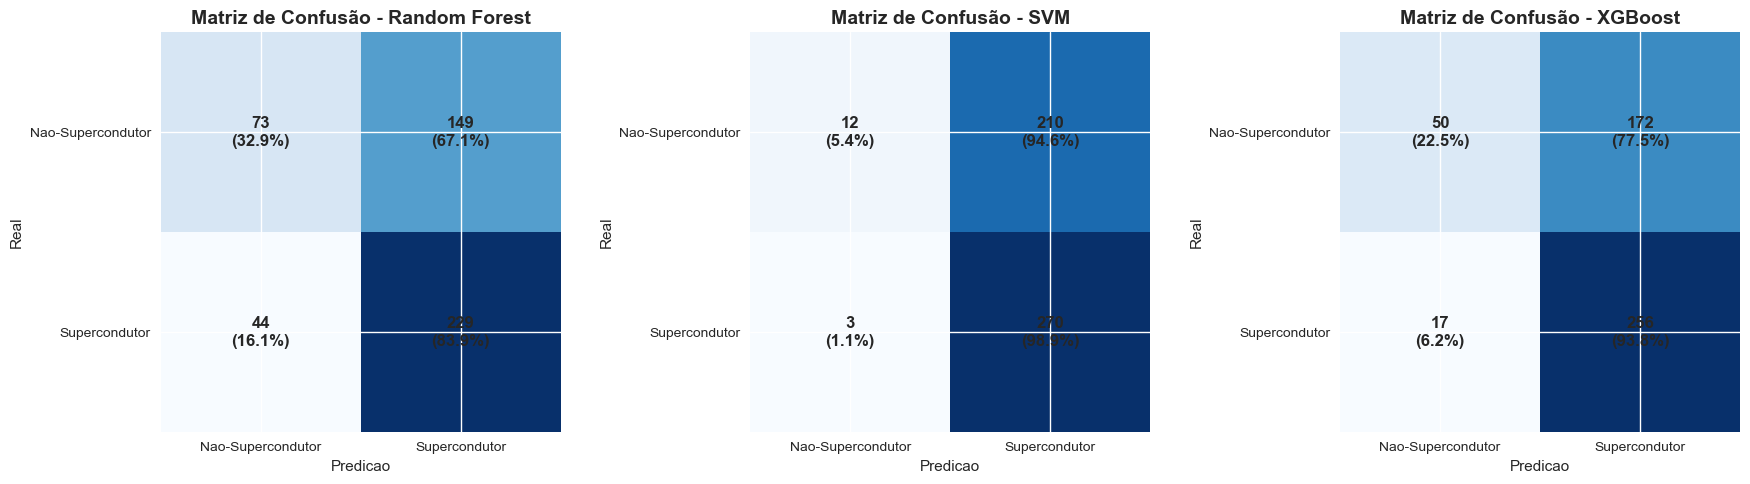

In [60]:
# Matrizes de confusão
if test_results and len(test_results) > 0:
    n_models = len(test_results)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, results_data) in enumerate(test_results.items()):
        cm = results_data['confusion_matrix']
        
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        annotations = np.empty_like(cm).astype(str)
        for row in range(cm.shape[0]):
            for col in range(cm.shape[1]):
                annotations[row, col] = f'{cm[row, col]}\n({cm_percent[row, col]:.1f}%)'
        
        # Plota heatmap
        im = axes[i].imshow(cm, interpolation='nearest', cmap='Blues')
        axes[i].set_title(f'Matriz de Confusão - {model_name}', fontsize=14, fontweight='bold')
        
        for row in range(cm.shape[0]):
            for col in range(cm.shape[1]):
                axes[i].text(col, row, annotations[row, col], 
                           ha='center', va='center', fontsize=12, fontweight='bold')
        
        axes[i].set_xlabel('Predicao')
        axes[i].set_ylabel('Real')
        axes[i].set_xticks([0, 1])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticklabels(['Nao-Supercondutor', 'Supercondutor'])
        axes[i].set_yticklabels(['Nao-Supercondutor', 'Supercondutor'])
    
    plt.tight_layout()
    plt.savefig('graficos_supercondutores/04_matrizes_confusao.png', dpi=300, bbox_inches='tight')
    plt.show()

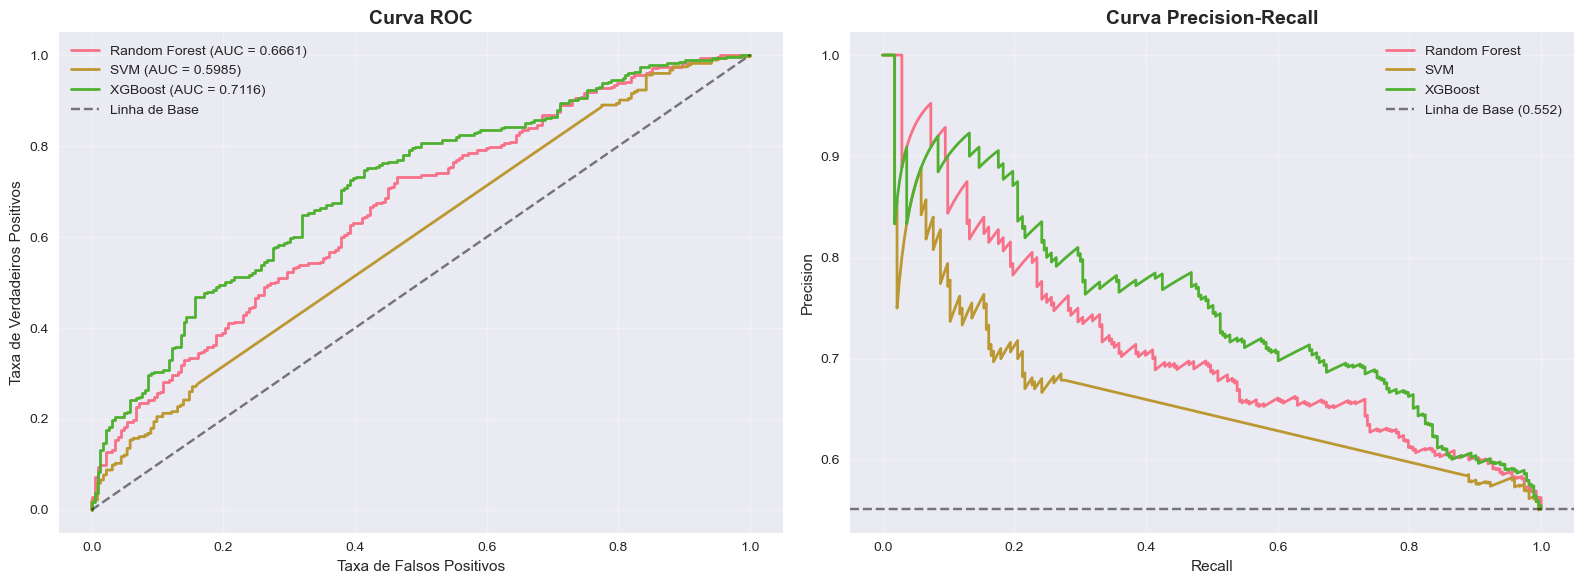

In [61]:
# Curvas ROC
if test_results and len(test_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Curva ROC
    for model_name, results_data in test_results.items():
        fpr, tpr, _ = roc_curve(y_test, results_data['y_pred_proba'])
        auc_score = results_data['auc']
        
        axes[0].plot(fpr, tpr, linewidth=2, 
                    label=f'{model_name} (AUC = {auc_score:.4f})')
    
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Linha de Base')
    axes[0].set_xlabel('Taxa de Falsos Positivos')
    axes[0].set_ylabel('Taxa de Verdadeiros Positivos')
    axes[0].set_title('Curva ROC', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Curva Precision-Recall
    for model_name, results_data in test_results.items():
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, results_data['y_pred_proba'])
        
        axes[1].plot(recall_curve, precision_curve, linewidth=2, 
                    label=f'{model_name}')
    
    # Linha de base (proporção da classe positiva)
    baseline = y_test.mean()
    axes[1].axhline(y=baseline, color='k', linestyle='--', alpha=0.5, 
                   label=f'Linha de Base ({baseline:.3f})')
    
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Curva Precision-Recall', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('graficos_supercondutores/05_curvas_roc_pr.png', dpi=300, bbox_inches='tight')
    plt.show()

## 10. Feature Importance

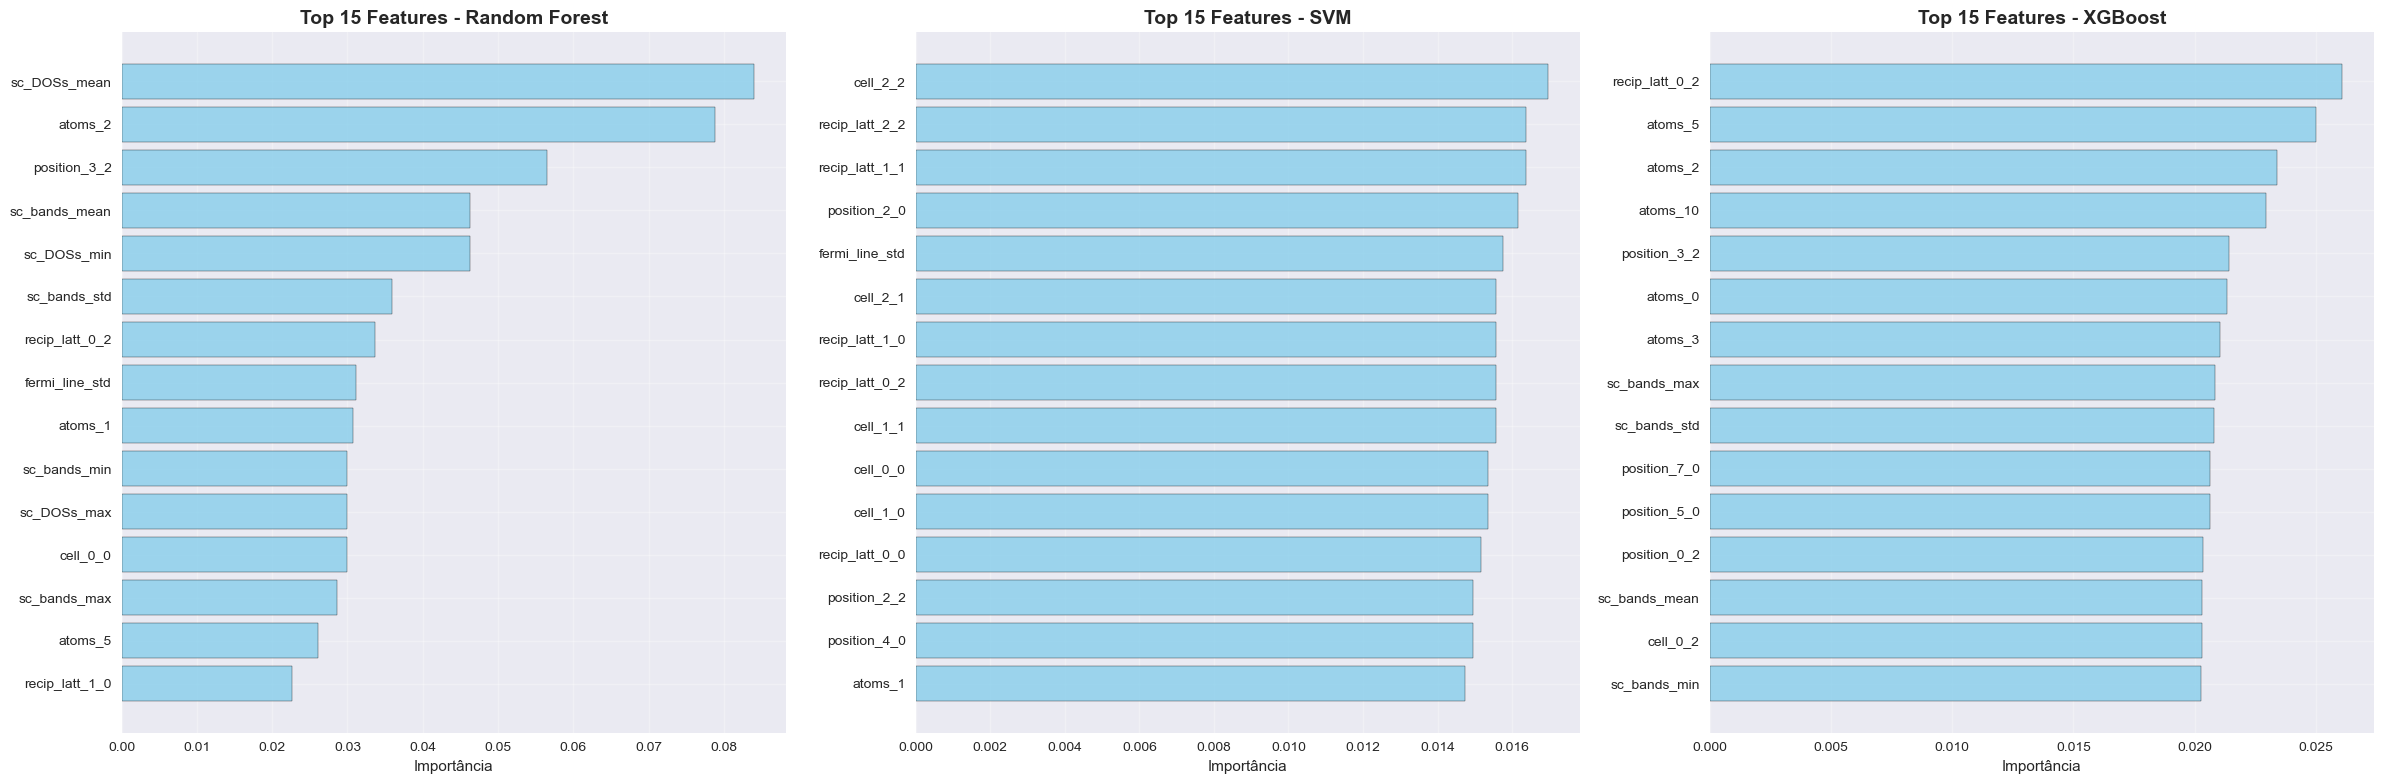


Top 10 features mais importantes por modelo:

Random Forest:
   1. sc_DOSs_mean                   | 0.0840
   2. atoms_2                        | 0.0788
   3. position_3_2                   | 0.0565
   4. sc_bands_mean                  | 0.0463
   5. sc_DOSs_min                    | 0.0463
   6. sc_bands_std                   | 0.0359
   7. recip_latt_0_2                 | 0.0337
   8. fermi_line_std                 | 0.0311
   9. atoms_1                        | 0.0307
  10. sc_bands_min                   | 0.0300

SVM:
   1. cell_2_2                       | 0.0170
   2. recip_latt_2_2                 | 0.0164
   3. recip_latt_1_1                 | 0.0164
   4. position_2_0                   | 0.0162
   5. fermi_line_std                 | 0.0158
   6. cell_2_1                       | 0.0156
   7. recip_latt_0_2                 | 0.0156
   8. recip_latt_1_0                 | 0.0156
   9. cell_1_1                       | 0.0156
  10. cell_0_0                       | 0.0154

XGBoost:
  

In [62]:
# Análise de Feature Importance
if best_models:
    
    feature_importance_data = {}
    
    for model_name, model in best_models.items():
        try:
            if hasattr(model, 'feature_importances_'):
                # Random Forest e XGBoost
                importances = model.feature_importances_
            elif hasattr(model, 'coef_'):
                # SVM linear
                importances = np.abs(model.coef_[0])
            else:
                from sklearn.inspection import permutation_importance
                perm_importance = permutation_importance(
                    model, X_test_scaled, y_test, n_repeats=10, random_state=42
                )
                importances = perm_importance.importances_mean
            
            feature_importance_data[model_name] = importances
            
        except Exception as e:
            print(f"   Não foi possível calcular feature importance para {model_name}: {e}")
    
    # Visualizacao das feature importances
    if feature_importance_data:
        n_models = len(feature_importance_data)
        fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 8))
        
        if n_models == 1:
            axes = [axes]
        
        for i, (model_name, importances) in enumerate(feature_importance_data.items()):
            # Cria DataFrame com importâncias
            importance_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': importances
            }).sort_values('Importance', ascending=True)
            
            # Plota top 15 features
            top_features = importance_df.tail(15)
            
            axes[i].barh(range(len(top_features)), top_features['Importance'], 
                        color='skyblue', alpha=0.8, edgecolor='black')
            axes[i].set_yticks(range(len(top_features)))
            axes[i].set_yticklabels(top_features['Feature'], fontsize=10)
            axes[i].set_xlabel('Importância')
            axes[i].set_title(f'Top 15 Features - {model_name}', fontsize=14, fontweight='bold')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('graficos_supercondutores/06_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Mostra top features de cada modelo
        print("\nTop 10 features mais importantes por modelo:")
        for model_name, importances in feature_importance_data.items():
            importance_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print(f"\n{model_name}:")
            for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
                print(f"  {i+1:2d}. {row['Feature']:<30} | {row['Importance']:.4f}")

## 11. Curvas de Aprendizado

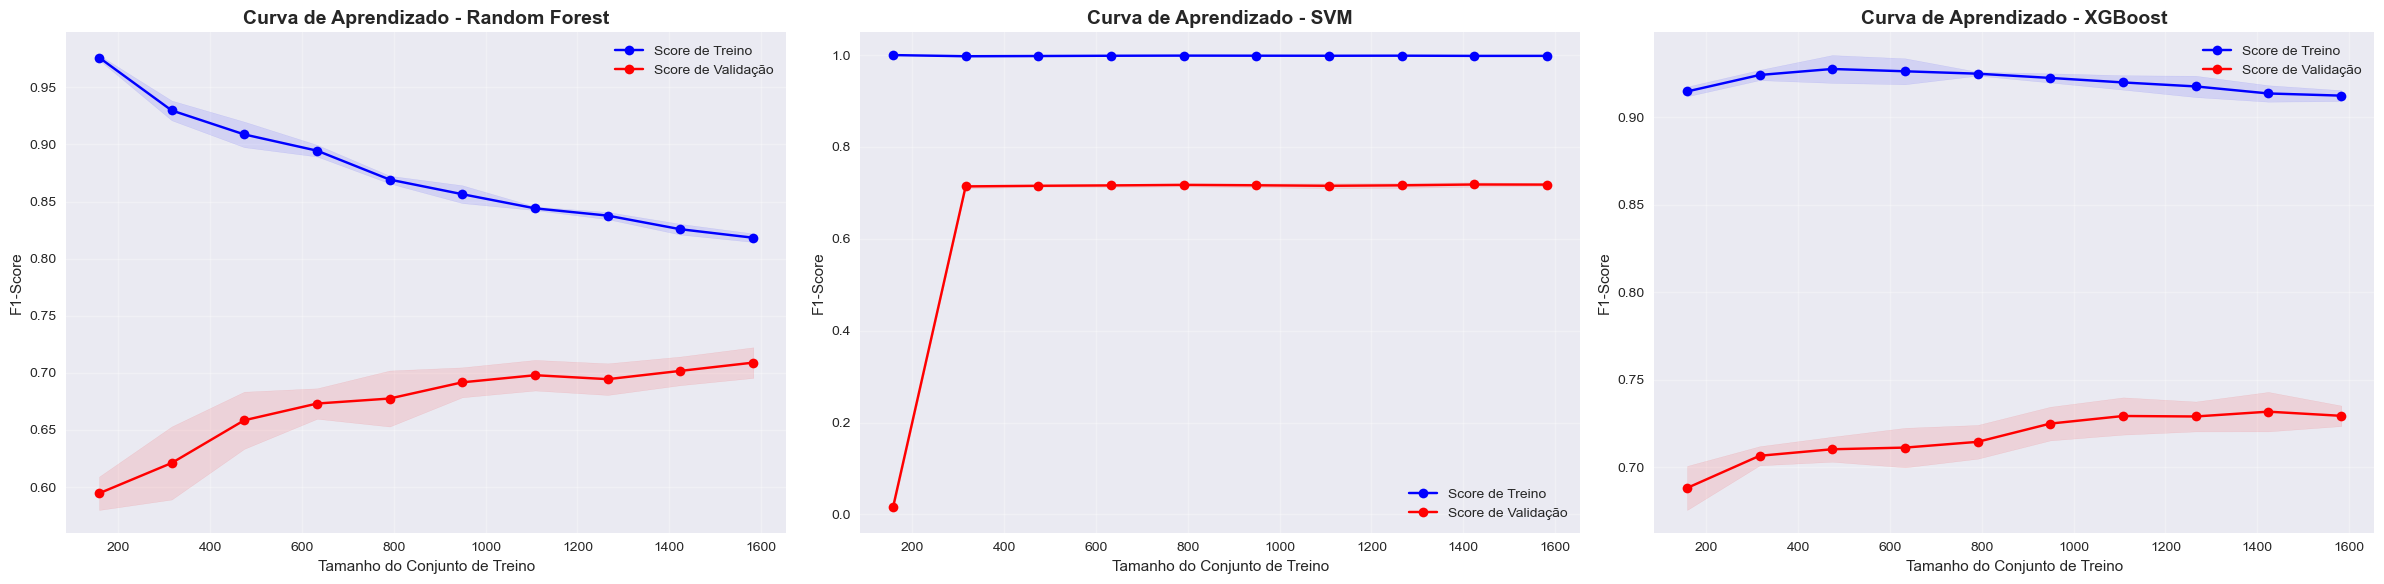

In [63]:
# Curvas de aprendizado
if best_models:
    
    n_models = len(best_models)
    fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 6))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, model) in enumerate(best_models.items()):
        try:
            # Calcula curvas de aprendizado
            train_sizes, train_scores, val_scores = learning_curve(
                model, X_train_scaled, y_train, 
                cv=5, n_jobs=-1, 
                train_sizes=np.linspace(0.1, 1.0, 10),
                scoring='f1'
            )
            
            # Calcula medias e desvios padrao
            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            val_mean = np.mean(val_scores, axis=1)
            val_std = np.std(val_scores, axis=1)
            
            # Plota curvas
            axes[i].plot(train_sizes, train_mean, 'o-', color='blue', 
                        label='Score de Treino')
            axes[i].fill_between(train_sizes, train_mean - train_std, 
                               train_mean + train_std, alpha=0.1, color='blue')
            
            axes[i].plot(train_sizes, val_mean, 'o-', color='red', 
                        label='Score de Validação')
            axes[i].fill_between(train_sizes, val_mean - val_std, 
                               val_mean + val_std, alpha=0.1, color='red')
            
            axes[i].set_xlabel('Tamanho do Conjunto de Treino')
            axes[i].set_ylabel('F1-Score')
            axes[i].set_title(f'Curva de Aprendizado - {model_name}', 
                             fontsize=14, fontweight='bold')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            
        except Exception as e:
            print(f"  Erro ao gerar curva de aprendizado para {model_name}: {e}")
            axes[i].text(0.5, 0.5, f'Erro: {str(e)[:50]}...', 
                        transform=axes[i].transAxes, ha='center', va='center')
            axes[i].set_title(f'Curva de Aprendizado - {model_name} (Erro)', 
                             fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('graficos_supercondutores/07_curvas_aprendizado.png', dpi=300, bbox_inches='tight')
    plt.show()

## 12. Final

In [64]:
metrics_df

,Modelo,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest,0.610101,0.605820,0.838828,0.703533,0.666073
1,SVM,0.569697,0.562500,0.989011,0.717131,0.598513
2,XGBoost,0.618182,0.598131,0.937729,0.730385,0.711596


In [65]:
print("CLASSIFICACAO DE SUPERCONDUTORES")
print("------------------------------------------------------------")
metrics_df['Media'] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].mean(axis = 1)

if test_results and len(test_results) > 0 and 'metrics_df' in locals():
    # Melhor modelo geral
    best_overall_model = metrics_df.loc[metrics_df['Media'].idxmax(), 'Modelo']
    best_f1_score = metrics_df['F1-Score'].max()
    
    print(f"\n🏆 MELHOR MODELO GERAL: {best_overall_model}")
    print(f"   Media: {best_f1_score:.4f}")
    
    print(f"   Parâmetros otimizados: {results[best_overall_model]['best_params']}")
    
    # Resumo
    print(f"\nRESUMO DE PERFORMANCE:")
    print(f"   Dataset: {len(X_final)} amostras, {X_final.shape[1]} features")
    print(f"   Classes: {(y == 0).sum()} nao-supercondutores, {y.sum()} supercondutores")
    print(f"   Balanceamento: {y.mean():.3f} (classe positiva)")
    
    print(f"\n PERFORMANCE POR MODELO:")
    for _, row in metrics_df.iterrows():
        print(f"   {row['Modelo']}:")
        print(f"     - Accuracy: {row['Accuracy']}")
        print(f"     - F1-Score: {row['F1-Score']}")
        print(f"     - AUC-ROC: {row['AUC-ROC']}")
    
    # Recomendações
    print(f"\n💡 RECOMENDACOES:")
    
    # Baseado na performance
    if best_f1_score > 0.8:
        print(f"   ✅ Excelente performance! O modelo {best_overall_model} está pronto para produção.")
    elif best_f1_score > 0.7:
        print(f"   ✅ Boa performance. O modelo {best_overall_model} pode ser usado com monitoramento.")
    else:
        print(f"     Performance moderada.")

    print(f"\n RESUMO:")
    print(f"   Modelo recomendado: {best_overall_model}")
    print(f"   Confiança: {'Alta' if best_f1_score > 0.8 else 'Média' if best_f1_score > 0.6 else 'Baixa'}")
    
else:
    print("nenhum modelo foi treinado com sucesso.")

CLASSIFICACAO DE SUPERCONDUTORES
------------------------------------------------------------

🏆 MELHOR MODELO GERAL: XGBoost
   Media: 0.7304
   Parâmetros otimizados: {'subsample': 0.6, 'scale_pos_weight': 5, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8}

RESUMO DE PERFORMANCE:
   Dataset: 2474 amostras, 50 features
   Classes: 1112 nao-supercondutores, 1362 supercondutores
   Balanceamento: 0.551 (classe positiva)

 PERFORMANCE POR MODELO:
   Random Forest:
     - Accuracy: 0.6101010101010101
     - F1-Score: 0.7035330261136713
     - AUC-ROC: 0.666072666072666
   SVM:
     - Accuracy: 0.5696969696969697
     - F1-Score: 0.7171314741035857
     - AUC-ROC: 0.5985133485133485
   XGBoost:
     - Accuracy: 0.6181818181818182
     - F1-Score: 0.7303851640513552
     - AUC-ROC: 0.7115962115962116

💡 RECOMENDACOES:
   ✅ Boa performance. O modelo XGBoost pode ser usado com monitoram

## 13. Salvamento dos Modelos

In [66]:
# Salva os modelos treinados
if best_models:
    try:
        import joblib
        
        # Cria diretório para salvar
        os.makedirs('modelos_supercondutores', exist_ok=True)
        
        # Salva modelos
        for model_name, model in best_models.items():
            filename = f"modelos_supercondutores/{model_name.lower().replace(' ', '_')}_model.pkl"
            joblib.dump(model, filename)
            print(f"   ✓ {model_name} salvo em {filename}")
        
        # Salva scaler
        joblib.dump(scaler, 'modelos_supercondutores/scaler.pkl')
        
        # Salva feature names
        joblib.dump(selected_features, 'modelos_supercondutores/selected_features.pkl')
        
        # Salva resultados se disponíveis
        if 'metrics_df' in locals() and metrics_df is not None:
            metrics_df.to_csv('modelos_supercondutores/resultados_comparacao.csv', index=False)
        
    except Exception as e:
        print(f" Erro ao salvar modelos: {e}")
else:
    print(" Nenhum modelo foi treinado para salvar.")

   ✓ Random Forest salvo em modelos_supercondutores/random_forest_model.pkl
   ✓ SVM salvo em modelos_supercondutores/svm_model.pkl
   ✓ XGBoost salvo em modelos_supercondutores/xgboost_model.pkl
